In [1]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate


Assumptions:

1. Constant liquid hold up on each plate 
2. Constant liquid and vapor flow in each of the three sections of the column
3. Constant hold up in reboiler and condenser

In [16]:
def mod(t,var):
    
    x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = var
    
    D = 0.3*(F3+F7)
    L1 = reflux*D
    V = L1 + D
    L2 = F3 + L1
    L3 = F7 + L2
    
    y0 = (α*x0)/(1+(α-1)*x0)
    y1 = (α*x1)/(1+(α-1)*x1)
    y2 = (α*x2)/(1+(α-1)*x2)
    y3 = (α*x3)/(1+(α-1)*x3)
    y4 = (α*x4)/(1+(α-1)*x4)
    y5 = (α*x5)/(1+(α-1)*x5)
    y6 = (α*x6)/(1+(α-1)*x6)
    y7 = (α*x7)/(1+(α-1)*x7)
    y8 = (α*x8)/(1+(α-1)*x8)
    y9 = (α*x9)/(1+(α-1)*x9)
    y10 = (α*x10)/(1+(α-1)*x10)
    y11 = (α*x11)/(1+(α-1)*x11)
    
    dx0dt = (1/m_cond)*(y1*V - V*x0)
    
    dx1dt = (1/m_tray)*(V*(y2-y1) + L1*(x0-x1))
    dx2dt = (1/m_tray)*(V*(y3-y2) + L1*(x1-x2))
    
    dx3dt = (1/m_tray)*(V*(y4-y3) + L1*x2 - L2*x3 + xF*F3)
    
    dx4dt = (1/m_tray)*(V*(y4-y3) + L2*(x3-x4))
    dx5dt = (1/m_tray)*(V*(y5-y4) + L2*(x4-x5))
    dx6dt = (1/m_tray)*(V*(y6-y5) + L2*(x5-x6))
    
    dx7dt = (1/m_tray)*(V*(y8-y7) + L2*x6 - L3*x7 + xF*F7)
    
    dx8dt = (1/m_tray)*(V*(y9-y8) + L3*(x7-x8))
    dx9dt = (1/m_tray)*(V*(y10-y9) + L3*(x8-x9))
    dx10dt = (1/m_tray)*(V*(y11-y10) + L3*(x9-x10))
    
    dx11dt = (1/m_rebl)*(L3*x10 - x11*(F3+F7-D) - V*y11)
    
    return [dx0dt, dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt, dx7dt, dx8dt, dx9dt, dx10dt, dx11dt]

In [28]:
init =[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

F3 = 30/60 # Feed on plate 3
F7 = 30/60 # Feed on Plate 7
xF = 0.45 # mole fraction in feed
reflux = 0.7 # reflux ratio
m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.15 # holdup in reboiler
α = 1.5 # relative volatility

In [35]:
tspan = (0, 20)
t = np.linspace( *tspan, 100)

r = scipy.integrate.solve_ivp(mod, tspan, init, t_eval=t)

In [36]:
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = r.y

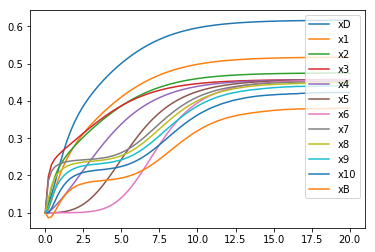

In [37]:
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [x]")
plt.legend(loc = "upper right")